# ISS Projekt 2023/24

Honza Pavlus, Honza Brukner a Honza Černocký, ÚPGM FIT VUT

6.11. 2023



## 1. Úvod

V projektu budete pracovat se biomedicínskými signály a to konkrétně se signálem elektrokardiogramu EKG. Vyzkoušíte si filtraci tohoto druhu signálu, abyste dostali krásné EKG křivky, které můžete vidět ve filmech. Dále si zkusíte vybudovat jednoduchý, ale účinný detektor QRS a ti, kteří se vrhnou i na bonusový úkol, si zkusí odhalit srdeční patologii. K dispozici dostanete každý 3 nahrávky jednokanálového EKG signálu, jeden zdravý a dva s různými patologiemi.

Projekt je nejlépe možno řešit v Python-u a to přímo v dodaném Python notebooku, který si můžete zkopírovat do vlastního Google Colabu. Projekt je také možno řešit v Matlab-u, Octave, Julii, jazyce C, Java nebo v libovolném jiném programovacím či skriptovacím jazyce. Je možné použít libovolné knihovny. Projekt se nezaměřuje na “krásu programování”, není tedy nutné mít vše úhledně zabalené do okomentovaných funkcí (samozřejmě se ale okomentovaný kód lépe opravuje a to hlavně v případě podivných výsledků), ošetřené všechny chybové stavy, atd. Důležitý je výsledek.

**Vaši práci odevzdáváte vyexportovanou do dvou souborů: (1) do PDF souboru login.pdf, (2) do Python notebooku login.ipynb. PDF musí obsahovat výsledky prokazatelně vytvořené Vaším kódem.** V případě řešení projektu v jiném jazyce nebo prostředí než v dodaném Python notebooku, je prvním souborem protokol v PDF, druhý soubor je archiv s Vaším kódem. Ten musí být spustitelný na standardní fakultní distribuci Windows nebo Linuxu.

## 3. Vstup
Pro řešení projektu má každý student/ka k disposici osobní soubor se  zdravým signálem (sinusovým rytmem): ***login.wav***, kde login je váš xlogin popřípadě VUT číslo (pro studenty FSI). Dále jsou k disposici  ještě další dva signály: ***FIS.wav*** a ***KES.wav***. První signál obsahuje fibrilaci a druhý komorovou extrasystolu. Tyhle dva soubory jsou pro všechny společné a využijete je při řešení bonusového úkolu.

In [20]:
#Načtení Vašeho signálu - xlogin99 nahraďte Vaším loginem
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt, resample, freqz, tf2zpk, filtfilt, spectrogram

#!wget https://www.fit.vutbr.cz/study/courses/ISS/public/proj2023-24/xmrkva04.wav

data, fs = sf.read("xmrkva04.wav")
    


## 4. Úkoly



### 4.1. [2.5b] Nahrání a zobrazení EKG signálu

Nezapomeňte na popisy os u jednotlivých grafů.

 a) [1b] Nahrajte EKG signál login.wav, vyberte 5-sekundový úsek a zobrazte ho v časové doméně. Pro nahrání signálu použijte knihovny numpy a soundfile.

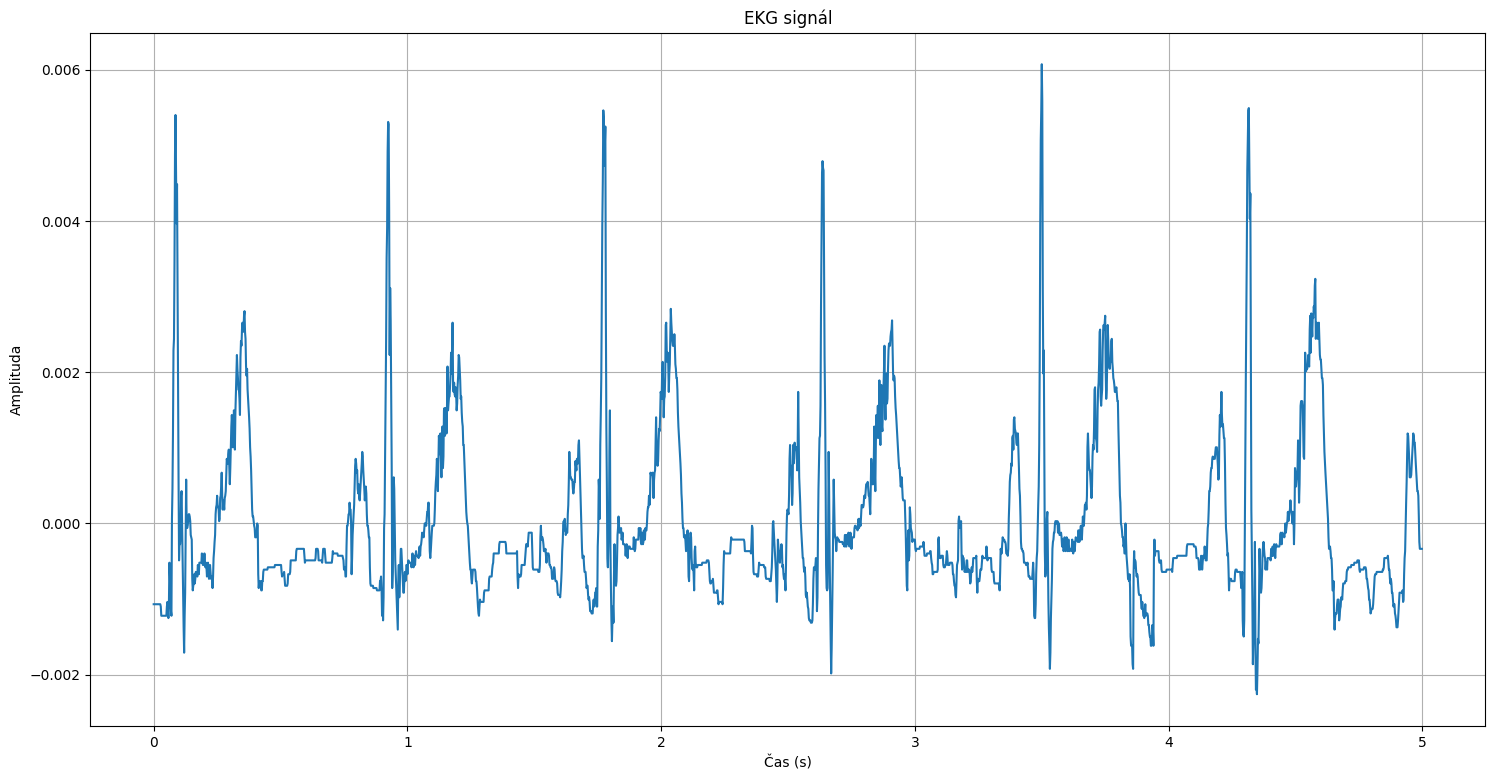

In [21]:
class Signal:
    def __init__(self, data, fs):
        self.data = data
        self.fs = fs
        self.time_axis = np.arange(0, len(data) / fs, 1 / fs)

    def plot_signal(self):
        return self.time_axis, self.data

def cut_segment(input, begin, end):
    segment = input.data[begin * input.fs : end * input.fs]
    return segment

signal = Signal(data, fs) 

signal_cut = Signal(cut_segment(signal, 0, 5), fs)

# Zobrazení v časové doméně
plt.figure(figsize=(18, 9))
plt.plot(*signal_cut.plot_signal())
plt.title("EKG signál")
plt.xlabel("Čas (s)")
plt.ylabel("Amplituda")
plt.grid(True)
plt.show()


b) [1b] Spočítejte spektrum z 5 sekundového úseku nahraného signálu a zobrazte jej.

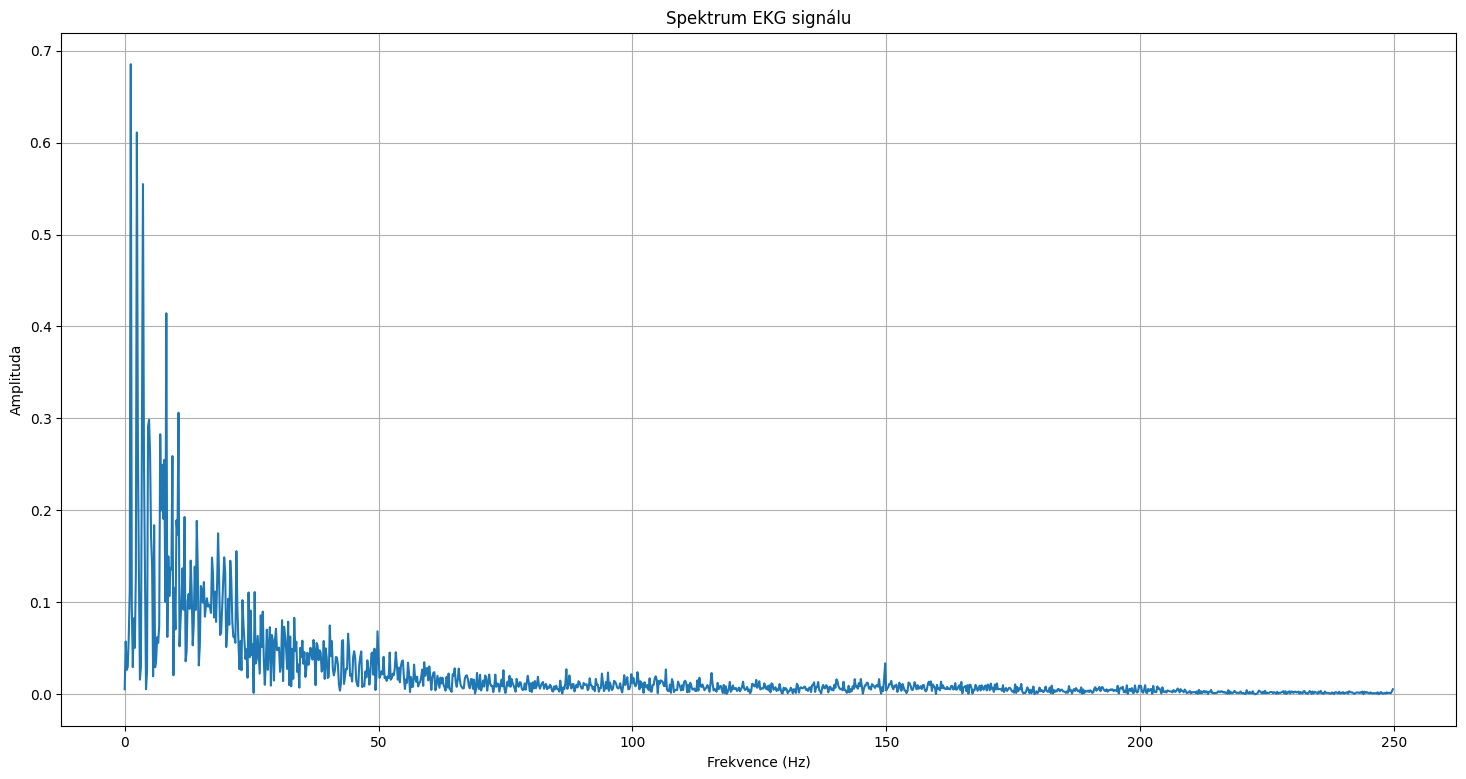

In [22]:
# Spočítání Fourierovy transformace
def do_dft(input):
    dft = np.abs(np.fft.fft(input.data))    # Proveď dft
    y = dft[:dft.size // 2]                 # Potřebuji jen kladnou půlku

    #freq = np.arange(dft.size//2) * (fs/segment.size)

    freq = np.fft.fftfreq(input.data.size, 1/input.fs)  # Úprava osy x na frekvence
    x = freq[:freq.size // 2]

    return x, y

# Zobrazení spektra
plt.figure(figsize=(18, 9))
plt.plot(*do_dft(signal_cut))
plt.title("Spektrum EKG signálu")
plt.xlabel("Frekvence (Hz)")
plt.ylabel("Amplituda")
plt.grid(True)
plt.show()

 c) [0.5b] Ve spektru vidíte rušení na 50Hz nebo 60Hz a jejich harmonických frekvencích. Vysvětlete, čím je způsobeno.

Rušení můžeme pozorovat zejména u frekvence 50 a 150 Hz, jelikož je zmíněno přímo 50/60Hz, odkazuje to nejspíše na rušení elektrické sítě.

### 4.2. [3b] Převzorkujte nahraný signál



a) [2b] Převzorkujte signál na vzorkovací frekvenci 100 Hz, nezapomeňte na filtr pro antialiasing. Můžete například odstranit část spektra od $\frac{Fs}{2}$ nebo použít filtr dolní propusti.

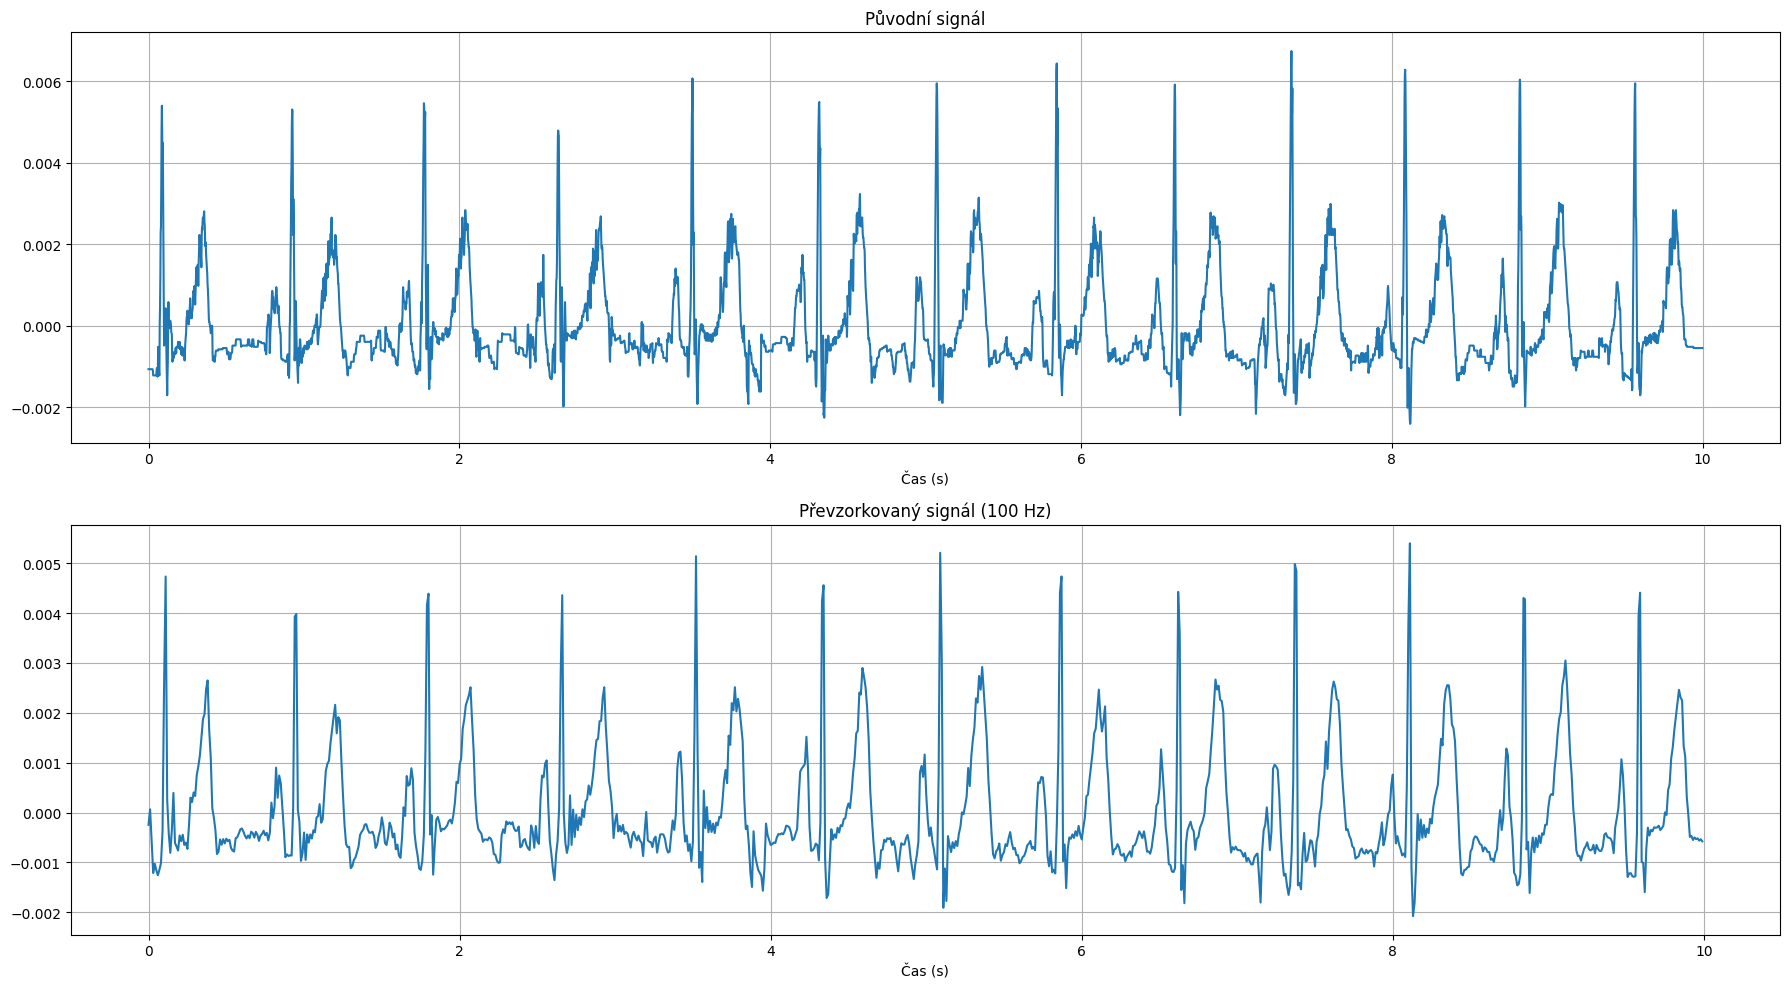

In [23]:
def do_resample(input, fs_res):
    cutoff_freq = fs_res / 2    # Příprava aa filtru
    sos = butter(10, cutoff_freq, fs=input.fs, output="sos")
    data_filtered = sosfilt(sos, input.data)    # Aplikace aa filtru

    data = resample(data_filtered, int(input.data.size * fs_res / input.fs))   # Provedení samotného převzorkování pomocí nachystaného filtru
    return data

fs_res = 100
signal_res = Signal(do_resample(signal, fs_res) , fs_res)

# Zobrazení původního signálu
plt.figure(figsize=(18, 10)) #sniž hodnoty pokud jsou grafy příliš velké
plt.subplot(2, 1, 1)
plt.plot(*signal.plot_signal())
plt.title("Původní signál")
plt.xlabel("Čas (s)")
plt.grid(True)

# Zobrazení převzorkovaného signálu
plt.subplot(2, 1, 2)
plt.plot(*signal_res.plot_signal())
plt.title("Převzorkovaný signál (100 Hz)")
plt.xlabel("Čas (s)")
plt.grid(True)

plt.tight_layout()
plt.show()

b) [1b] Zobrazte 5 sekundový úsek původního a převzorkovaného signálu v časové doméně a zobrazte i jejich spektra.

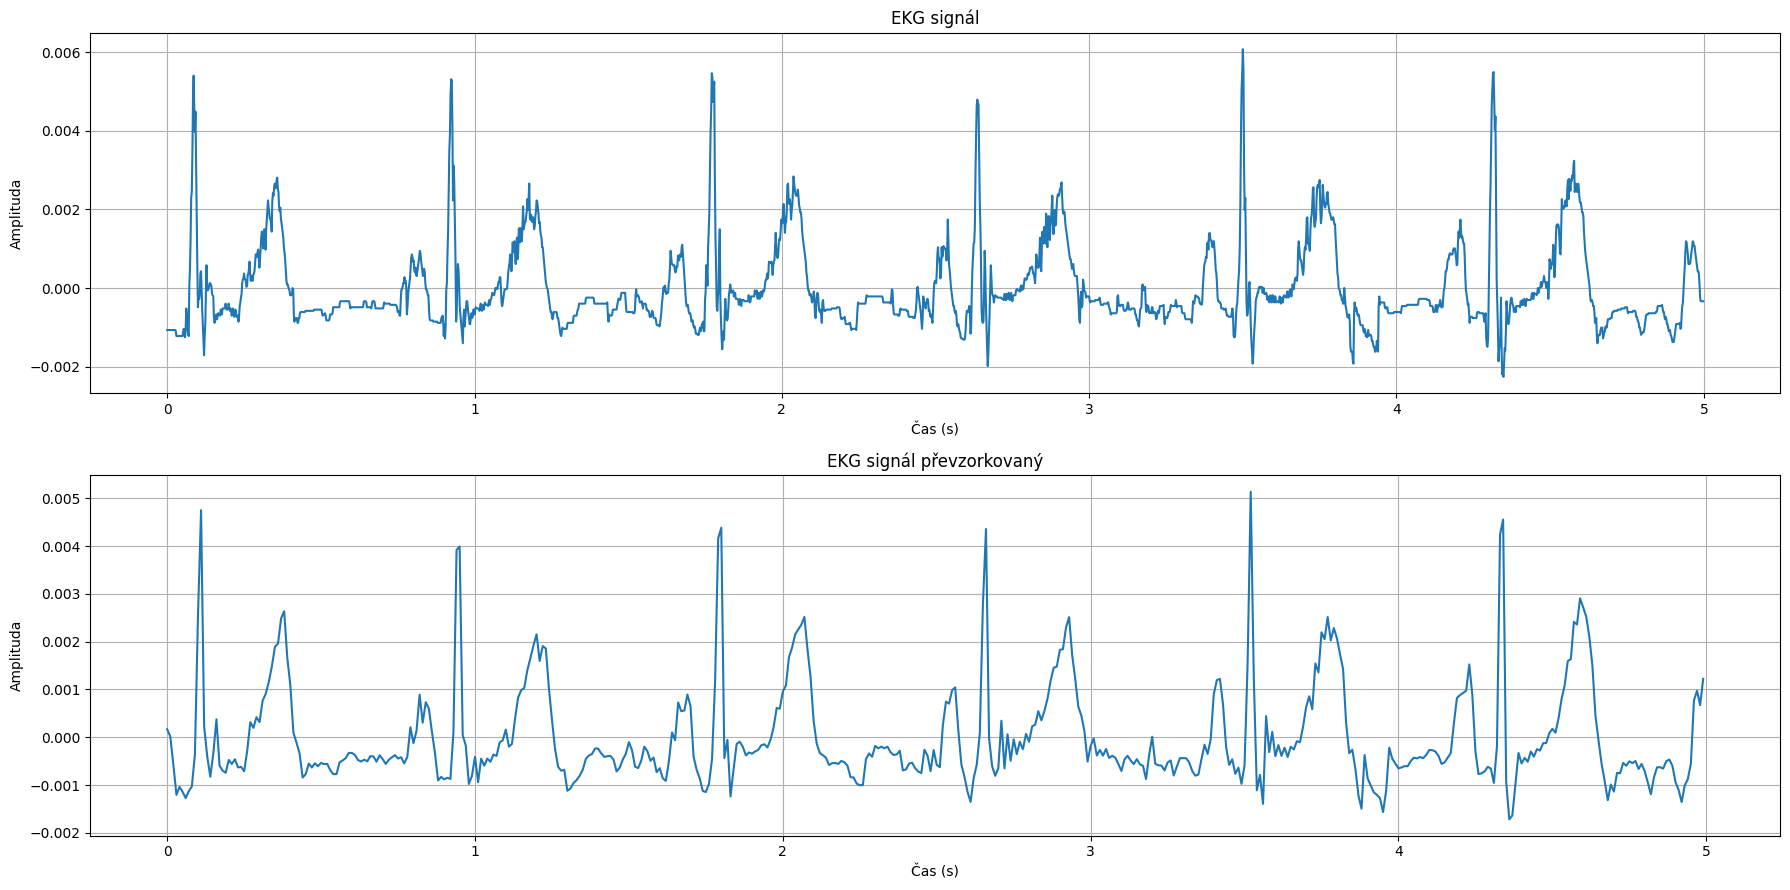

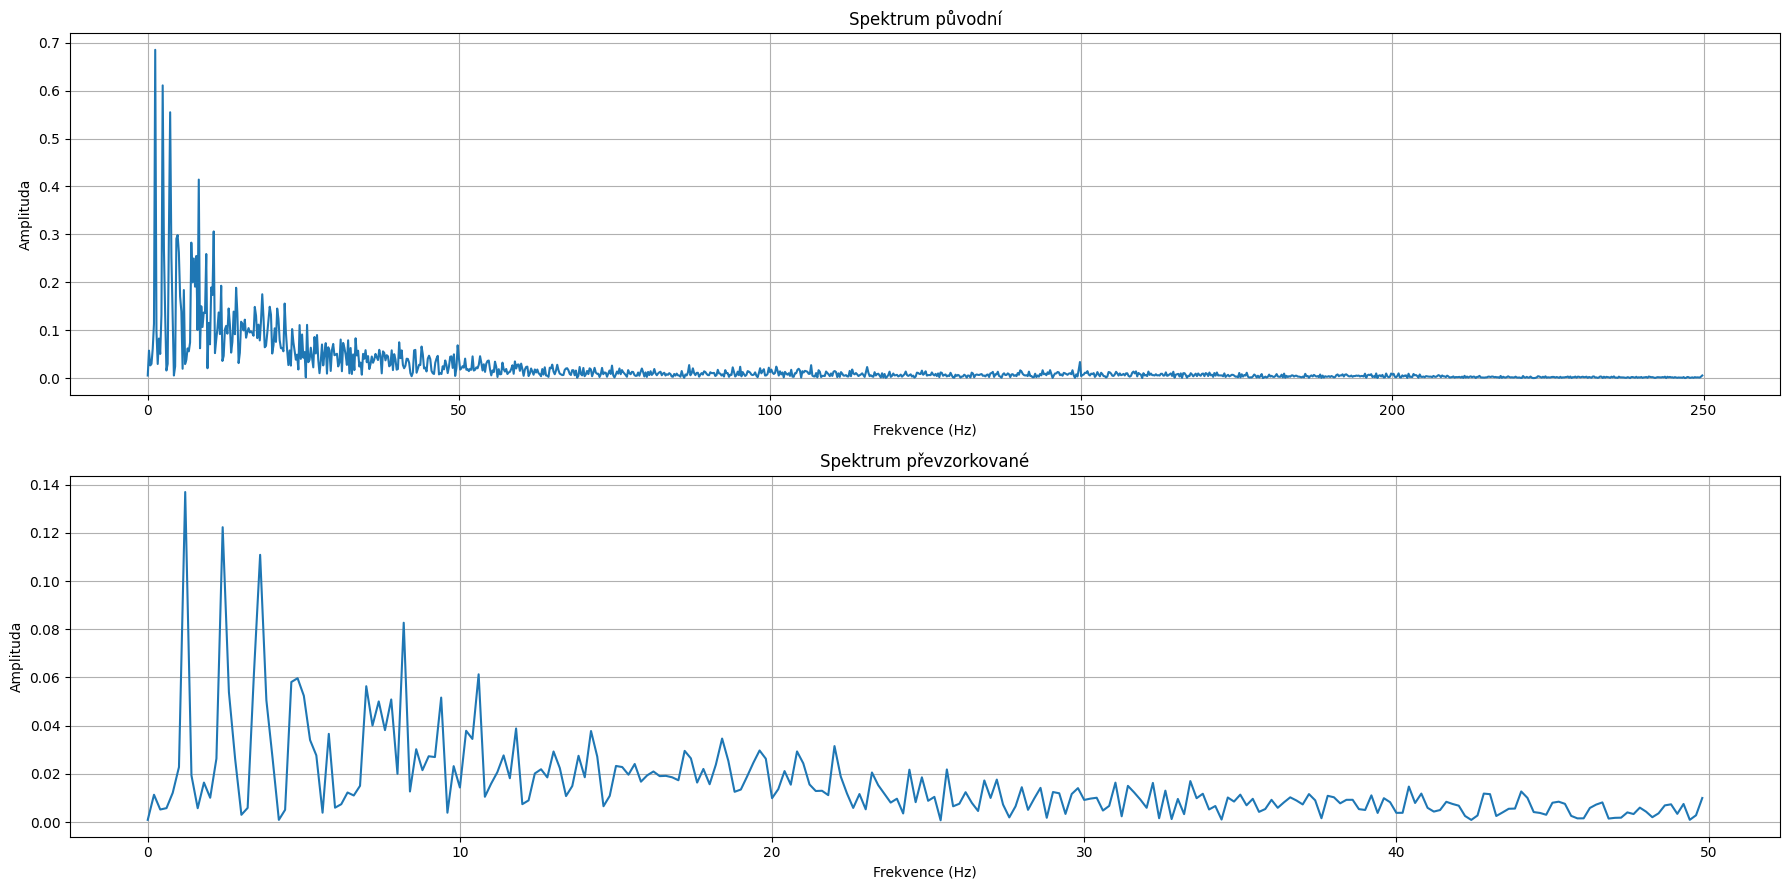

In [24]:
fs_res = 100
signal_cut_res = Signal(do_resample(signal_cut, fs_res) , fs_res)   # Převzorkování 5s signálu

# Zobrazení původního 5s signálu
plt.figure(figsize=(18, 9))
plt.subplot(2, 1, 1)
plt.plot(*signal_cut.plot_signal())
plt.title("EKG signál")
plt.xlabel("Čas (s)")
plt.ylabel("Amplituda")
plt.grid(True)

# Zobrazení převzorkovaného 5s signálu
plt.subplot(2, 1, 2)
plt.plot(*signal_cut_res.plot_signal())
plt.title("EKG signál převzorkovaný")
plt.xlabel("Čas (s)")
plt.ylabel("Amplituda")
plt.grid(True)
plt.tight_layout()
plt.show()

######################################
# DFT z úkolu 4.1
plt.figure(figsize=(18, 9))
plt.subplot(2, 1, 1)
plt.title("Spektrum původní")
plt.xlabel("Frekvence (Hz)")
plt.ylabel("Amplituda")
plt.grid(True)
plt.plot(*do_dft(signal_cut))

# DFT převzorkovaného 5s signálu
plt.subplot(2, 1, 2)
plt.title("Spektrum převzorkované")
plt.xlabel("Frekvence (Hz)")
plt.ylabel("Amplituda")
plt.grid(True)
plt.plot(*do_dft(signal_cut_res))
plt.tight_layout()
plt.show()

### 4.3. [4b] Vyfiltrujte nahraný signál pásmovou propustí 10Hz-20Hz

  




a) [2b] Vytvořte filtr pásmové propusti, možnosti jsou dvě: buďto filtrovat pomocí klasického návrhu filtrů, kde získáte koeficienty `a` a `b` (pomocí např. scipy.butter) a zobrazíte charakteristiku filtru + nuly a póly. Nebo se můžete vydat cestou filtrování ve frekvenční doméně, frekvenční charakteristiku vykreslete pomocí spektrální masky.

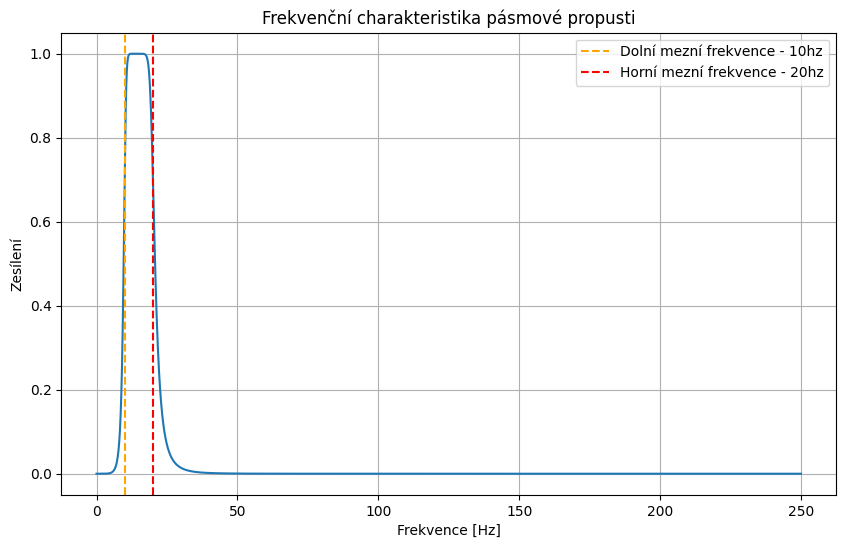

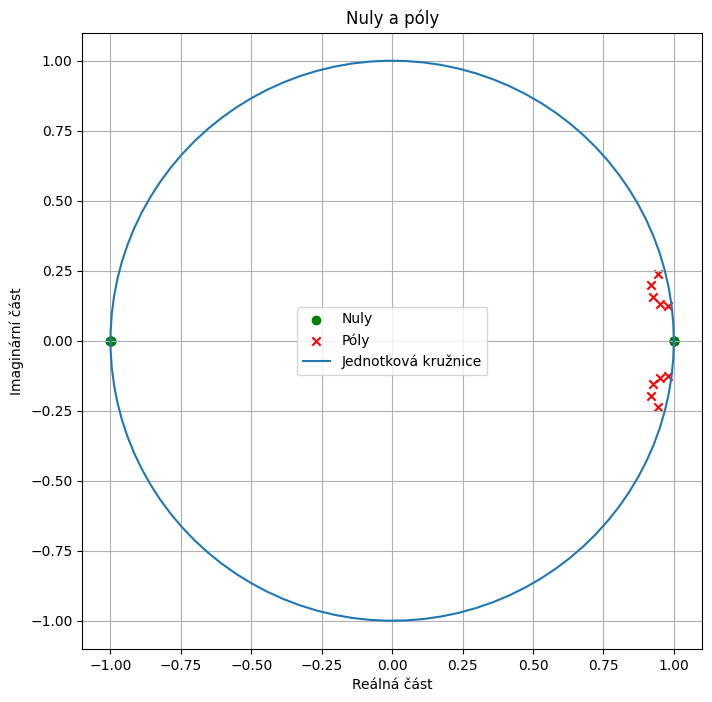

In [25]:
# Krajní hodnoty filtru a aplikace filtru
bottom = 10
top = 20  
filter = [bottom, top]
b, a = butter(5, filter, btype="band", fs=signal.fs)

# Výpočet nul a pólů
zeros, poles, _ = tf2zpk(b, a)

# Výpočet frekvenční odezvy filtru
w, h = freqz(b, a, worN=10000, fs=signal.fs) # w jsou frekvence, h jsou jejich impulzní odezvy, normalizováno na fs

# Frekvenční charakteristika filtru
plt.figure(figsize=(10, 6))
plt.plot(w, np.abs(h))
plt.title("Frekvenční charakteristika pásmové propusti")
plt.xlabel("Frekvence [Hz]")
plt.ylabel("Zesílení")
plt.axvline(bottom, color="orange", linestyle="--", label="Dolní mezní frekvence - 10hz")
plt.axvline(top,    color="red",    linestyle="--", label="Horní mezní frekvence - 20hz")
plt.legend()
plt.grid()
plt.show()

# Nuly a póly
plt.figure(figsize=(8, 8))
plt.scatter(np.real(zeros), np.imag(zeros), marker="o", color="g", label="Nuly")
plt.scatter(np.real(poles), np.imag(poles), marker="x", color="r", label="Póly")

# Jednotková kružnice
phi = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(phi), np.sin(phi), linestyle="-", label="Jednotková kružnice")
plt.title("Nuly a póly")
plt.xlabel("Reálná část")
plt.ylabel("Imaginární část")
plt.legend()
plt.grid()
plt.show()

  b) [1b] Použijte navržený filtr na nahraný signál. Pokud máte navržený klasický filtr, proveďte filtrování z obou stran, abyste se vyhnuli fázovému posunu, to za vás zajistí například funkce scipy.signal.filtfilt. Vykreslete původní a vyfiltrovaný signál v časové doméně a spočítejte a zobrazte jejich spektra.


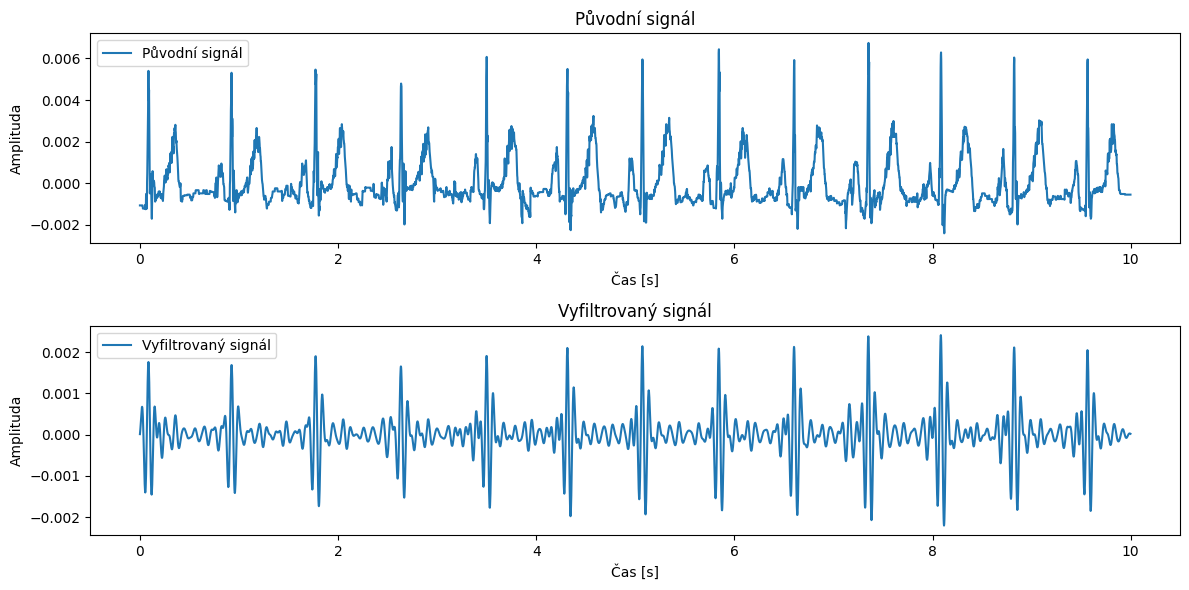

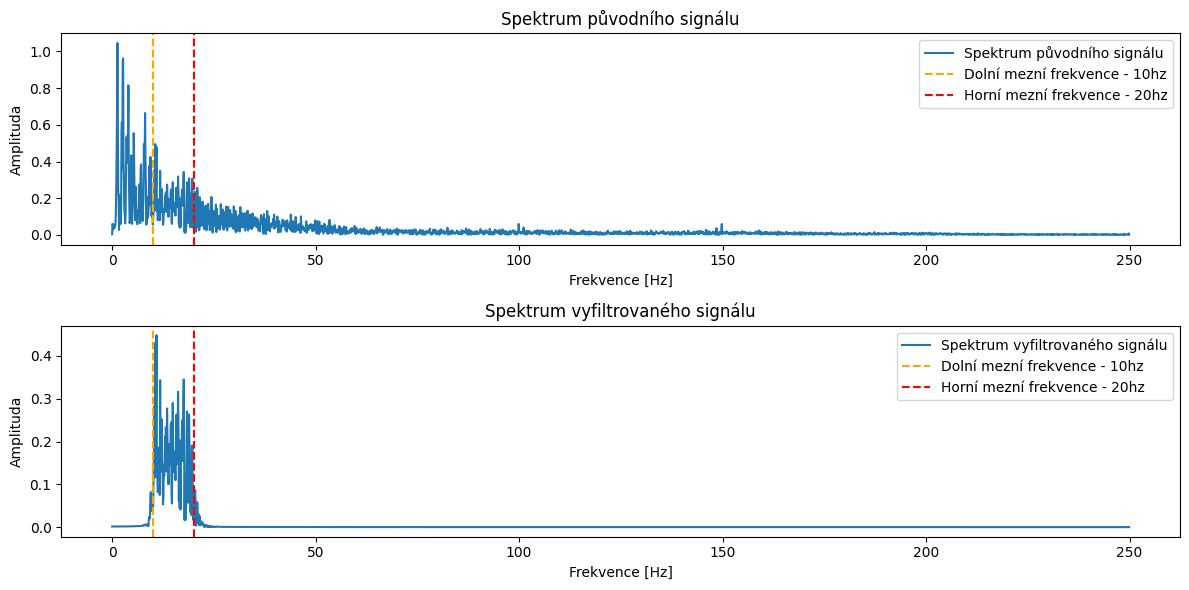

In [26]:
# Filtrování signálu

signal_fil = Signal(filtfilt(b, a, signal.data), signal.fs)

# Vykreslení původního signálu v časové doméně
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(*signal.plot_signal(), label='Původní signál')
plt.title('Původní signál')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.legend()

# Vykreslení vyfiltrovaného signálu v časové doméně
plt.subplot(2, 1, 2)
plt.plot(*signal_fil.plot_signal(), label='Vyfiltrovaný signál')
plt.title('Vyfiltrovaný signál')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.legend()

plt.tight_layout()
plt.show()

#Vykreslení DFT původního signálu v časové doméně DFT
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(*do_dft(signal), label='Spektrum původního signálu')
plt.axvline(bottom, color="orange", linestyle="--", label="Dolní mezní frekvence - 10hz")
plt.axvline(top,    color="red",    linestyle="--", label="Horní mezní frekvence - 20hz")
plt.title('Spektrum původního signálu')
plt.xlabel('Frekvence [Hz]')
plt.ylabel('Amplituda')
plt.legend()

#Vykreslení DFT vyfiltrovaného signálu v časové doméně DFT
plt.subplot(2, 1, 2)
plt.plot(*do_dft(signal_fil), label='Spektrum vyfiltrovaného signálu')
plt.axvline(bottom, color="orange", linestyle="--", label="Dolní mezní frekvence - 10hz")
plt.axvline(top,    color="red",    linestyle="--", label="Horní mezní frekvence - 20hz")
plt.title('Spektrum vyfiltrovaného signálu')
plt.xlabel('Frekvence [Hz]')
plt.ylabel('Amplituda')
plt.legend()

plt.tight_layout()
plt.show()


  c) [1b] Okomentujte rozdíl mezi filtrovaným a nefiltrovaným signálem a jejich spektry. Pokud bychom použili filtrování pouze z jedné strany (obyčejnou konvoluci), jaké je teoreticky největší posunutí ve vzorcích, které se může objevit a proč?



Spektrum filtrovaného signálu je teď správně omezeno pouze na zadané frekvence 10-20hz. 

Pokud bych použil obyčejnou konvoluci, mohlo by dojít k časovému posunutí až do poloviny délky filtru, tedy při fs = 500 na 10 vteřinách až o 2500 vzorků.

### 4.4. [3b] Vytvořte detektor QRS v časové doméně. Detekované QRS komplexy uložte do vhodné struktury a zároveň zobrazte graf v časové ose se zvýrazněnými QRS detekcemi.

   a) [1b] Detekujte QRS v převzorkovaném vyfiltrovaném signálu pomocí tresholdu (prahu). Pro tuto detekci musíte nejdříve získat vzorek jednoho QRS ze signálu, spočítat si maximální amplitudu a jako treshold vzít vámi určené procento této hodnoty. **Dávejte pozor na možnost otočeného QRS v signálu.** Do vykresleného signálu s detekcemi vykreslete i čáru udávající použitý treshold.

detected qrs:  [  7   8  10  11  13  14  91  92  94  95  97  98 176 179 180 182 183 186
 262 265 266 268 269 348 349 351 352 353 355 356 358 359 430 431 433 434
 436 437 440]


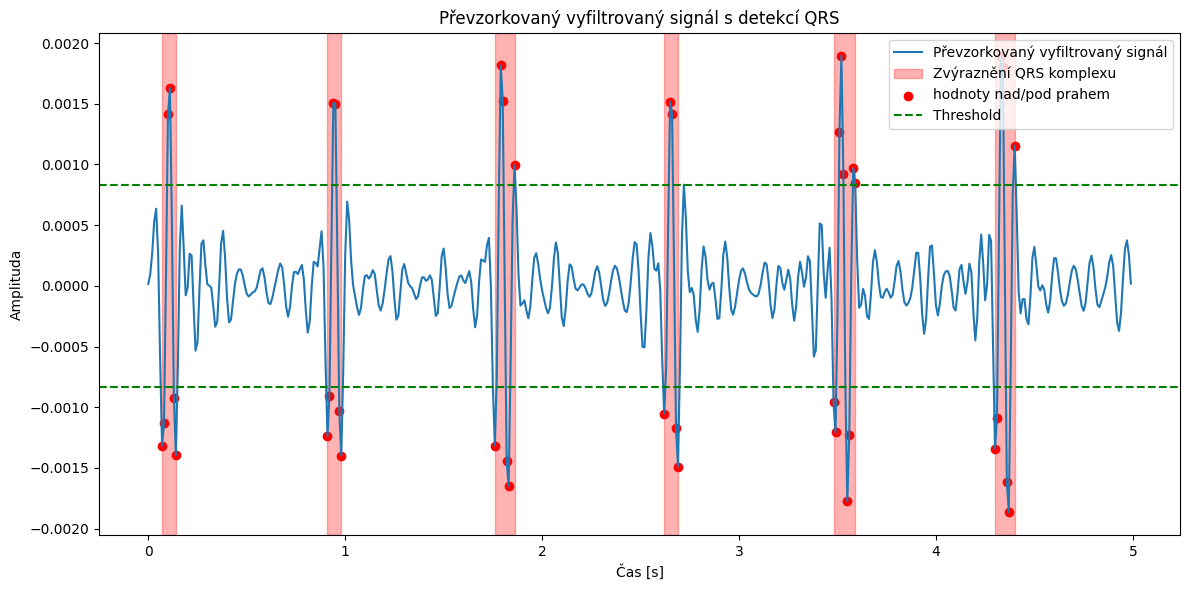

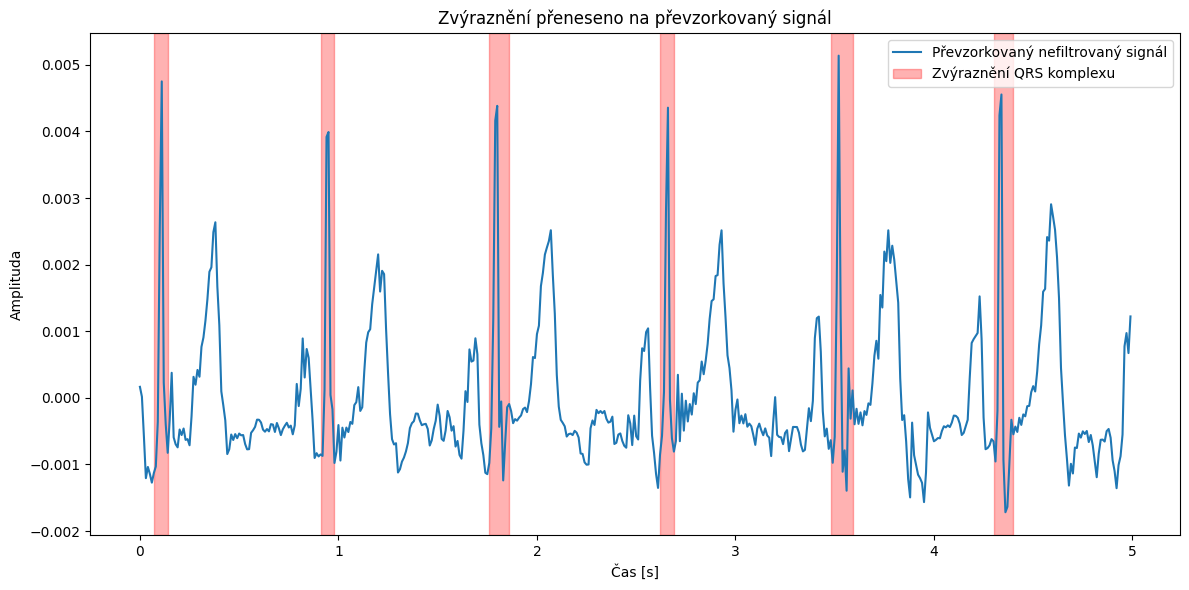

In [27]:
def highlight(input, detected_qrs): # Pomocna funkce pro zvýraznění jednotlivých skupin bodů
    index = 0
    begin = detected_qrs[0]
    end = detected_qrs[0]
    x = input.time_axis

    # Procházení všech hodnot v detected_qrs
    while index < detected_qrs.size - 1:

        current_qrs = detected_qrs[index]
        next_qrs = detected_qrs[index + 1]

        # Zkontrolovat vzdálenost od následující hodnoty
        if ((next_qrs - current_qrs) > (fs_res * 0.5)):    # Pokud je dál než 50% fs (50)    
            plt.axvspan(x[begin], x[end], alpha=0.3, color='red')
            begin = detected_qrs[index + 1]
            end = detected_qrs[index + 1]

        # Pro poslední skupinu 
        elif ((input.data.size - current_qrs) < (fs_res * 0.7)):    # Pokud jsme blízko ke konci (blíž než 70% fs)
            end = detected_qrs[-1]
            plt.axvspan(x[begin], x[end], alpha=0.3, color='red', label= 'Zvýraznění QRS komplexu')
            break

        end = detected_qrs[index + 1]
        index += 1
    return

def detect_qrs(input, threshold_percentage=44): # Pomocná funkce pro detekci všech bodů nad nebo pod prahem
    max_amplitude = np.max(np.abs(input.data))
    threshold = max_amplitude * (threshold_percentage / 100)

    qrs_positive = np.where(input.data > threshold)[0]
    qrs_negative = np.where(input.data < -threshold)[0]
    
    detected_qrs = np.sort(np.concatenate((qrs_positive, qrs_negative)))
    
    return detected_qrs, threshold


# Aplikace filtru na převzorkovaný signál
b_res, a_res = butter(5, filter, btype="band", fs=signal_cut_res.fs)    # Potřebuju filtr na fs = 100
signal_cut_res_fil = Signal(filtfilt(b_res, a_res, signal_cut_res.data), signal_cut_res.fs)

# Nalezení qrs
detected_qrs, threshold = detect_qrs(signal_cut_res_fil)
print("detected qrs: ", detected_qrs)

# Vykreslení výsledků
plt.figure(figsize=(12, 6))
plt.plot(*signal_cut_res_fil.plot_signal(), label='Převzorkovaný vyfiltrovaný signál')

highlight(signal_cut_res_fil ,detected_qrs)

plt.scatter(signal_cut_res_fil.time_axis[detected_qrs], signal_cut_res_fil.data[detected_qrs], c='red', label='hodnoty nad/pod prahem')
plt.axhline(threshold, color='green', linestyle='--', label='Threshold')
plt.axhline(-threshold, color='green', linestyle='--')
plt.title('Převzorkovaný vyfiltrovaný signál s detekcí QRS')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.legend()
plt.tight_layout()

plt.figure(figsize=(12, 6))
plt.plot(*signal_cut_res.plot_signal(), label='Převzorkovaný nefiltrovaný signál')

highlight(signal_cut_res_fil ,detected_qrs)

plt.title('Zvýraznění přeneseno na převzorkovaný signál')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.legend()
plt.tight_layout()
plt.show()

b) [2b] Detekujte QRS v signálu pomocí autokorelace v převzorkovaném nefiltrovaném signálu. Pro tuto detekci musíte nejdříve získat vzorek jednoho QRS ze signálu. Dále budete autokorelovat signál právě s tímto výstřižkem. QRS se budou nacházet na místech, kde vám budou vycházet vysoké hodnoty korelace. Do vykresleného signálu s detekcemi zaznačte i vámi zvolený výstřižek.

[ 14  98 183 269 355 437]


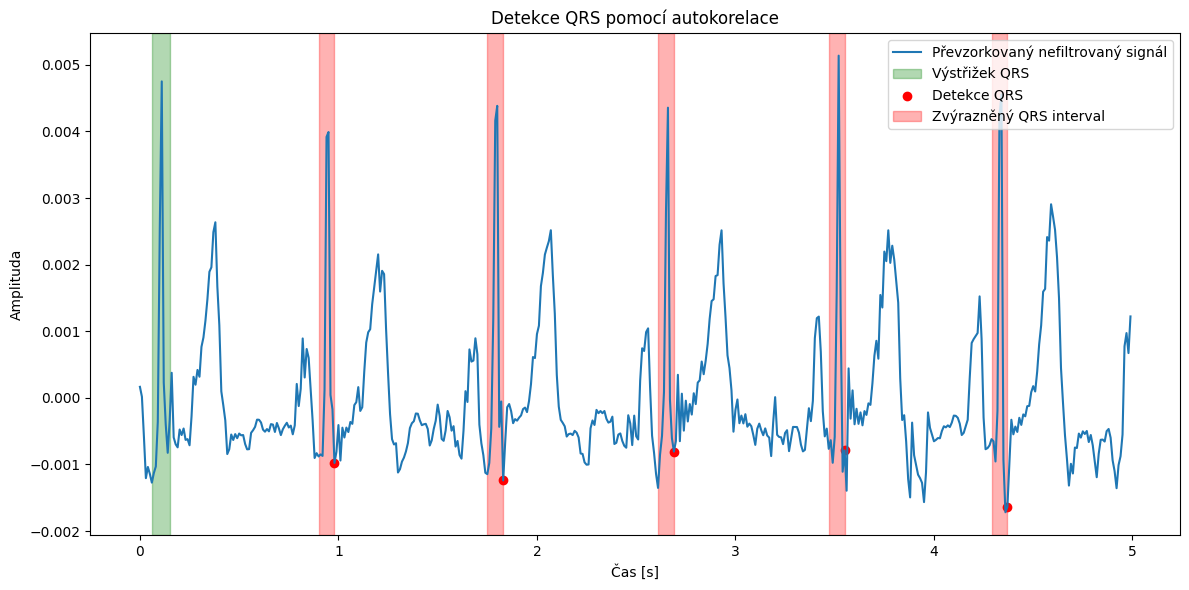

In [28]:
# Získání prvního qrs - mám přesné výsledky z předchozího příkladu
# Pokud se změní výřez 5 sekund, je potřeba přepsat tyto hodnoty!
qrs_start = 6
qrs_end = 15
sample_qrs = signal_cut_res.data[qrs_start:qrs_end]

# Provedení autokorelace
autocorrelation = np.correlate(signal_cut_res.data, sample_qrs, mode='full')

# Určení prahu
threshold_autocorr = 0.8 * np.max(autocorrelation) # 80%

# Získání všech podobných částí
qrs_locations = np.where(autocorrelation > threshold_autocorr)[0]
print(qrs_locations)

x = signal_cut_res.time_axis

plt.figure(figsize=(12, 6))
plt.plot(*signal_cut_res.plot_signal(), label='Převzorkovaný nefiltrovaný signál')
plt.axvspan(x[qrs_start], x[qrs_end], alpha=0.3, color='green', label='Výstřižek QRS')
qrs_locations = qrs_locations[1:]
plt.scatter(x[qrs_locations], signal_cut_res.data[qrs_locations], c='red', label='Detekce QRS')

# Zvýreznění několika vzorků před detekovaným QRS pro zvýraznění komplexů
label_added = False
for qrs in qrs_locations:
    plt.axvspan(x[qrs], x[qrs-8], alpha=0.3, color='red', label= '' if label_added else 'Zvýrazněný QRS interval')
    label_added = True
label_added = False

plt.title('Detekce QRS pomocí autokorelace')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.legend()
plt.tight_layout()
plt.show()

### 4.5. [3.5b] Vytvořte detektor QRS v frekvenční doméně a detekované QRS zakreslete jako v předchozí úloze 4.4

a) [2b] Detekujte QRS pomocí použití spektrogramu. Spočítejte a zobrazte spektrogram nahraného převzorkovaného filtrovaného signálu. Použijte parametry, `hop_size=120ms`a `window_len=200ms`, popřípadě si zkuste s těmito parametry pohrát. Spektrogram dále normalizujte v čase. Spočítejte sumy energie spektra pro jednotlivé časové biny. Dále vytvořte práh podle hodnoty energie spektra u prvního vámi zvoleného QRS komplexu. Tento práh použijte pro detekci zbylých QRS komplexů v signálu.

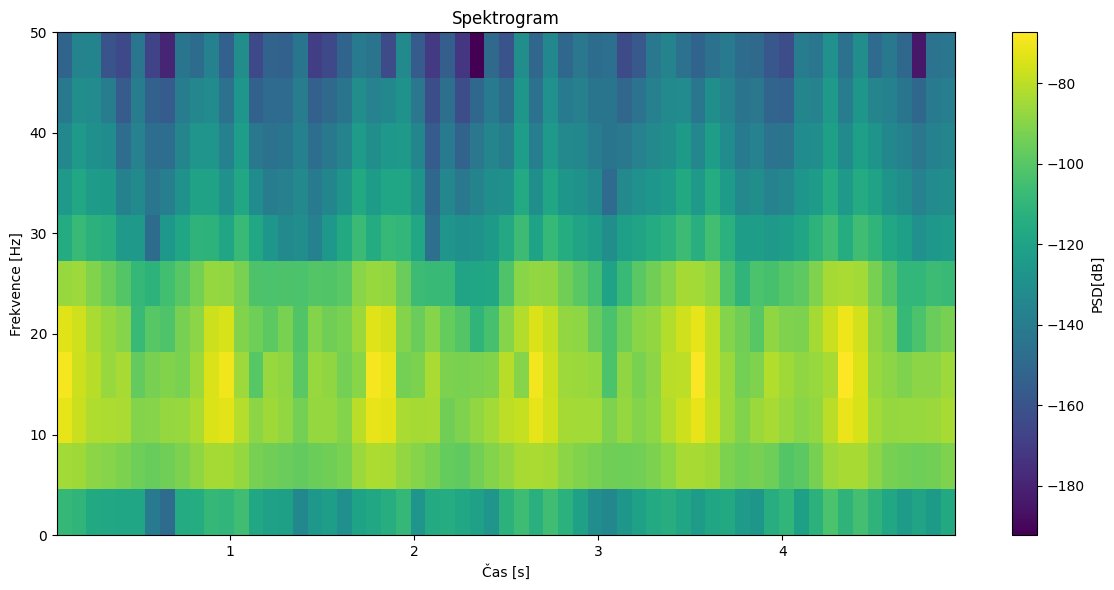

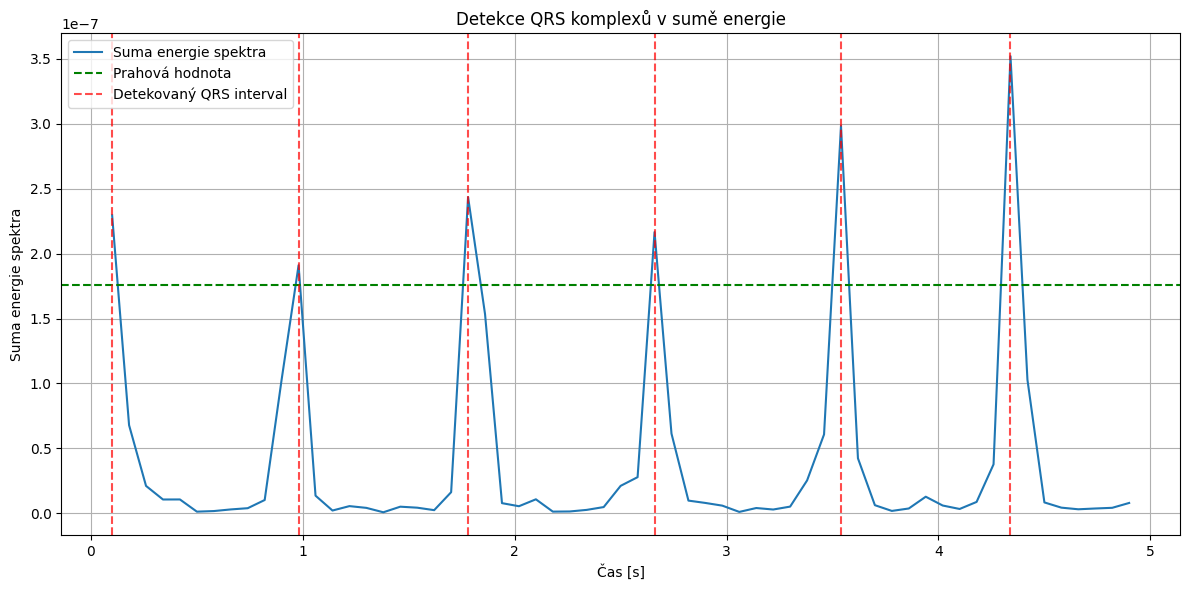

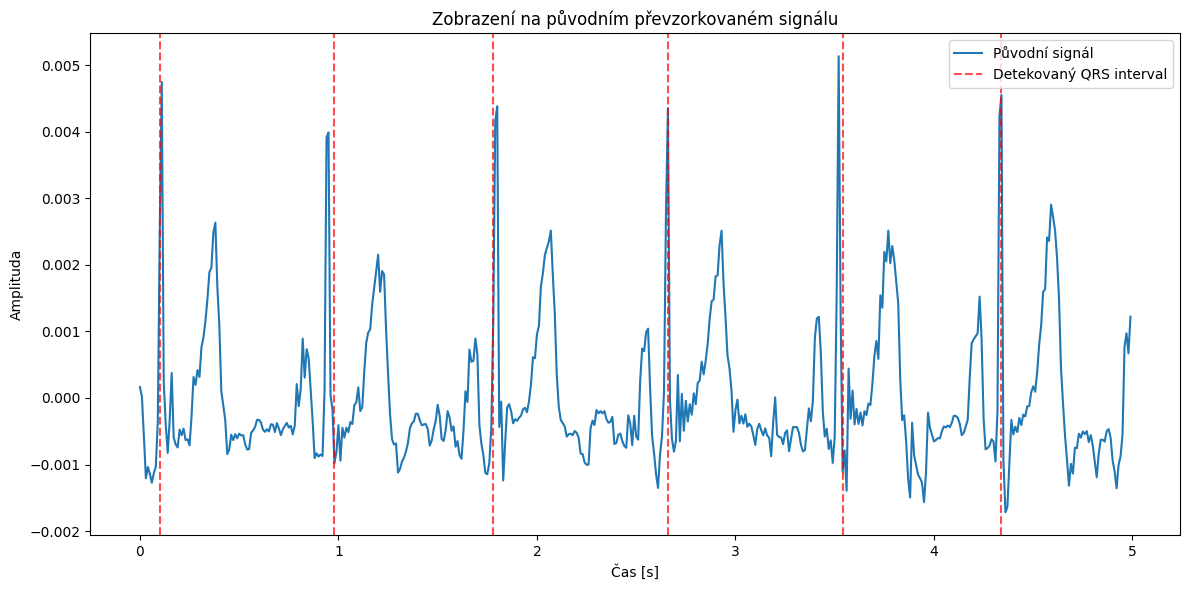

In [29]:
hop_size = 120/1000 * signal_cut_res_fil.fs  # normalizace hodnot do sekund
window_len = 200/1000 * signal_cut_res_fil.fs

# Vykreslení spektrogramu
plt.figure(figsize=(12, 6))
spectrum, freqs, t, im = plt.specgram(signal_cut_res_fil.data, Fs=signal_cut_res_fil.fs, NFFT=int(window_len), noverlap=int(hop_size))
plt.colorbar(label='PSD[dB]')
plt.xlabel('Čas [s]')
plt.ylabel('Frekvence [Hz]')
plt.title('Spektrogram')
plt.tight_layout()
plt.show()

# Výpočet sumy energie spektra pro jednotlivé časové biny
energy_sum = np.sum(spectrum, axis=0)

# Nalezení indexu pro výpočet thresholdu
index = np.argmax(energy_sum)
multiplier = 0.5                              # Násobek prahové hodnoty 50%
threshold = multiplier * energy_sum[index]    # Výpočet prahové hodnoty

# Detekce QRS komplexů pomocí thresholdu
qrs = np.where(energy_sum > threshold)[0]

# Vykreslení výsledků detekce QRS komplexů
plt.figure(figsize=(12, 6))
plt.plot(t, energy_sum, label='Suma energie spektra')
plt.axhline(threshold, color='green', linestyle='--', label='Prahová hodnota')
label_added = False
for qrs_time in t[qrs]:
    plt.axvline(qrs_time, color='red', linestyle='--', alpha=0.7, label= '' if label_added else 'Detekovaný QRS interval')
    label_added = True
plt.xlabel('Čas [s]')
plt.ylabel('Suma energie spektra')
plt.title('Detekce QRS komplexů v sumě energie')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Vykreslení signálu s detekovanými QRS na původním časovém rámci
plt.figure(figsize=(12, 6))
plt.plot(*signal_cut_res.plot_signal(), label='Původní signál')
label_added = False
for qrs_time in t[qrs]:
    plt.axvline(qrs_time, color='red', linestyle='--', alpha=0.7, label= '' if label_added else 'Detekovaný QRS interval')
    label_added = True
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.title('Zobrazení na původním převzorkovaném signálu')
plt.legend()
plt.tight_layout()
plt.show()





b) [1b] Detekujte QRS pomocí použití obálek a Hilbertovy transformace.

Hilbertova transformace je spočítaná podle následujícího vzorce

$x_a = F^{-1}(F(x) 2U) = x + i y,$

kde F je Fourierova transformace a $F^{-1}$ je její zpětná varianta. $U$ je Heavisideova funkce neboli funkce jednotkového skoku, která je definována: $U(x):$

\begin{cases}
      0.5 & x=0 \\
      1 & 0<x<\frac{N}{2} \text{ pro  $N$  liché} \\
      0.5 & x=\frac{N}{2} \text{ pro  $N$  liché} \\
      1 & 0<x\le\frac{N}{2} \text{ pro  $N$  sudé} \\
      0 & jinak
\end{cases}

kde $N$ je počet koeficientů Fourierovy transformace - pokud není určeno jinak, je to počet vzorků signálu.

Jinými slovy obálku spočítate tak, že:

* Spočítáte FFT $F$ na filtrovaném a převzorkovaném signálu
* Vynulujete pravou symetrickou část spektra
* Levou část spektra vynasobíte 2 kromě prvního a prostředního binu (při sudém počtu frekvenčních binů).
* Provedete zpětnou FFT $F^{-1}$

Abyste získali obálku signálu, je třeba vzít absolutní hodnotu signálu získaného Hilbertovou transformací.

Obálku a signál vykreslete do jednoho grafu přes sebe, obálka by měla obalovat daný signál.

Detekci QRS poté provedete opět prahováním, tentokrát ale obálky signálu.


Při této úloze **nepoužívejte** funkci hilbert z knihovny scipy. Cílem je, abyste si ji napsali sami. Můžete ji použít pouze jako baseline pro porovnání vašich výsledků.



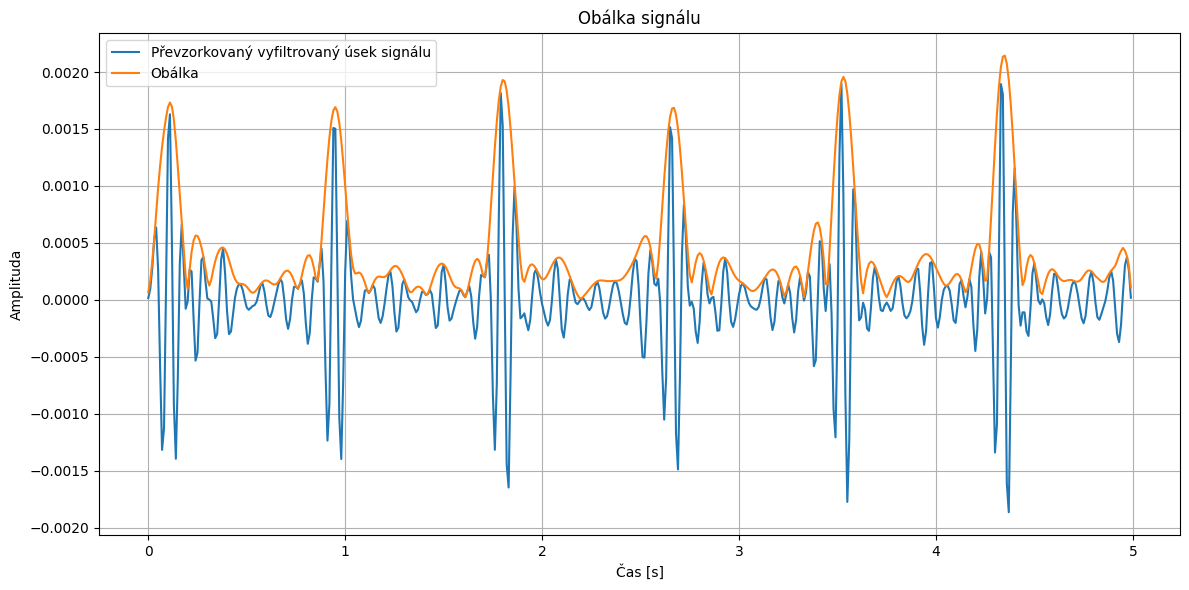

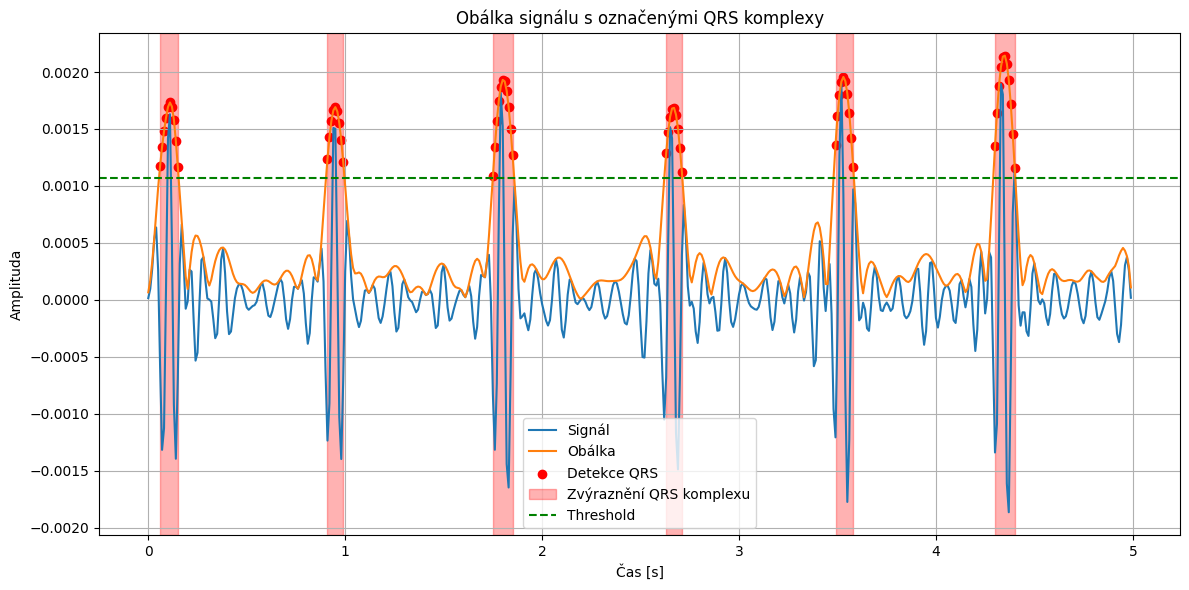

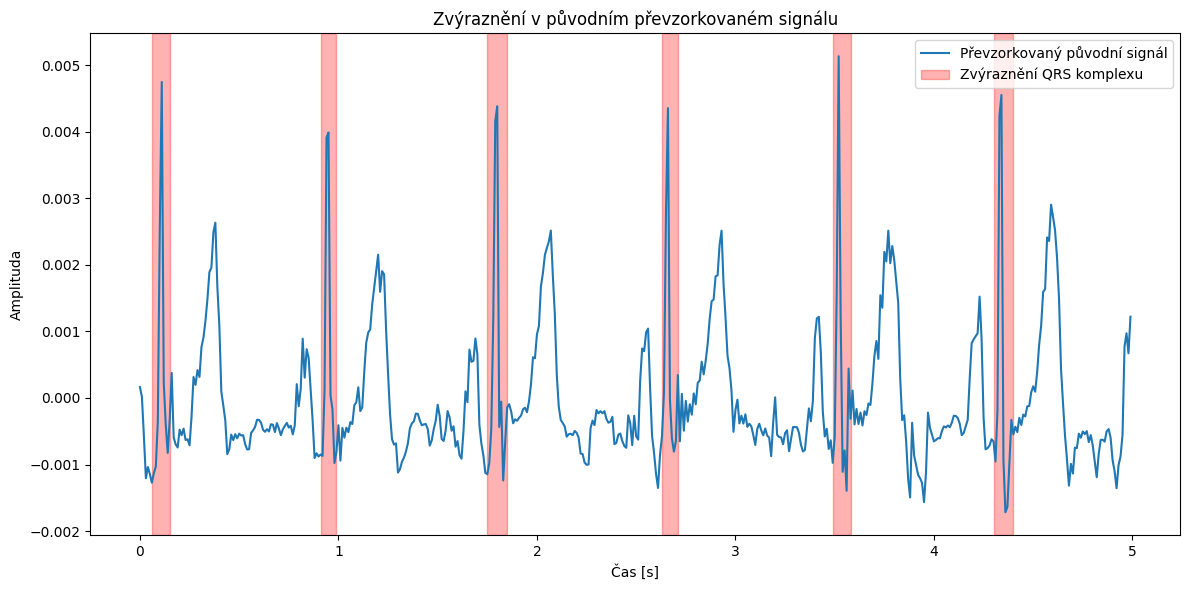

In [30]:
# Funkce pro Hilbertovu transformaci a výpočet obálky
def hilbert_envelope(input):
    
    # Spočítáte FFT $F$ na filtrovaném a převzorkovaném signálu
    fft = np.fft.fft(input)
    
    # Vynulujete pravou symetrickou část spektra
    fft[fft.size//2 + 1:] = 0
    
    # Levou část spektra vynasobíte 2 kromě prvního a prostředního binu (při sudém počtu frekvenčních binů).
    fft[1:fft.size//2] *= 2
    
    # Provedete zpětnou FFT
    hilbert = np.fft.ifft(fft)
    
    # Abyste získali obálku signálu, je třeba vzít absolutní hodnotu signálu získaného Hilbertovou transformací.
    envelope = np.abs(hilbert)
    
    return envelope

# Hilbertova transformace a obálka
envelope = hilbert_envelope(signal_cut_res_fil.data)

# Vykreslení výsledků
plt.figure(figsize=(12, 6))
plt.plot(*signal_cut_res_fil.plot_signal(), label='Převzorkovaný vyfiltrovaný úsek signálu')
plt.plot(signal_cut_res_fil.time_axis, envelope, label='Obálka')
plt.title('Obálka signálu')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Určení thresholdu a detekce QRS komplexů
threshold = np.max(envelope) * 0.5
detected_qrs_indices = np.where(envelope > threshold)[0]

# Vykreslení výsledků s označenými QRS komplexy
plt.figure(figsize=(12, 6))
plt.plot(*signal_cut_res_fil.plot_signal(), label='Signál')
plt.plot(signal_cut_res_fil.time_axis, envelope, label='Obálka')
plt.scatter(signal_cut_res_fil.time_axis[detected_qrs_indices], envelope[detected_qrs_indices], c='red', label='Detekce QRS')

highlight(signal_cut_res, detected_qrs_indices)

plt.axhline(threshold, color='green', linestyle='--', label='Threshold')
plt.title('Obálka signálu s označenými QRS komplexy')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.title('Zvýraznění v původním převzorkovaném signálu')
plt.plot(*signal_cut_res.plot_signal(), label='Převzorkovaný původní signál')

highlight(signal_cut_res, detected_qrs_indices)

plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.legend()
plt.tight_layout()
plt.show()


c) [0.5b] Při kterých metodách detekcí QRS nám vadí otočený (flipnutý) signál, při kterých ne a proč?

Otočený signál nám vadí při detekci QRS pomocí thresholdu, kde se musí hlídat pomocí záporného prahu. Naopak vůbec nám nevadí při obálce, která mi přijde spolu s autokorelací z mnou implementovaných metod nejpřesnější.

### 4.6 [2b] Detekce R-R intervalu

a)  Detekujte R-R intervaly pomocí detekovaných QRS z jednotlivých metod, které jste použili dříve. Vykreslete hodnoty R-R intervalu do stejného grafu jako EKG signál a detekované QRS. Vykreslení proveďte nad EKG signál, kde osa x bude i nadále časová a každý R-R interval bude zakreslen na x pozici detekovaného QRS. Osa y pro R-R interval bude určovat hodnotu samotného R-R intervalu.

Mělo by to vypadat přibližně takto (před odevzdáním smažte):
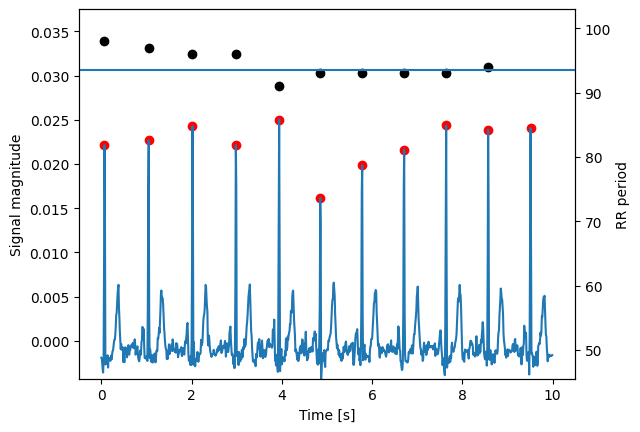

In [31]:
print(detected_qrs)

[  7   8  10  11  13  14  91  92  94  95  97  98 176 179 180 182 183 186
 262 265 266 268 269 348 349 351 352 353 355 356 358 359 430 431 433 434
 436 437 440]


### 4.7 Bonus

a) Načtěte si signál obsahující fibrilaci FIS.wav. Proveďte na něm filtrace a převzorkování. Poté zkuste použít nějaký QRS detektor. Z detekovaných QRS detekujte R-R intervaly. Porovnejte R-R intervaly pro fibrilaci a klasický signál bez patologie (sinusovy rytmus). Měli byste vidět prudké změny v R-R intervalech a jejich nepravidelnost. Zároveň se vám může stát, že vám některé metody detekce QRS nepodají tak kvalitní výkon jako při sinusovém rytmu.

In [32]:
# Zde napište váš kód

b) Načtěte si signál obsahující komorovou extrasystolu KES.wav. Proveďte na něm filtrace a převzorkování. Spočítejte a zobrazte spektrogram úseku tohoto signálu. Porovnejte spektrogramy vašeho signálu a signálu KES.wav. Měli byste vidět rozšířenou aktivitu na nízkých frekvencích. Dále zobrazte a porovnejte tyto signály v časové doméně. Obsažené komorové extrasystoly by se měly projevit jako zvláštní široké QRS.

In [33]:
# Zde napište váš kód